Victor CHAU & Tahar AMAIRI
# IFT 870 - Forage de données
## TP3 : onctions prédictives

### Sommaire

* 1. Implémentation de fonctions
    - a) ```model_score(class_model, X, y, params)```
    - b) ```bruteforce_optimisation(class_model, X, y, grille_param)```
    - c) ```randomize_optimisation(class_model, X, y, grille_param, sample_percent)```
    - d) ```halving_optimisation(class_model, X, y, grille_param, n_splitting)```
    - e) ```bayesian_optimisation(class_model, X, y, grille_param, s_size, n_iter)```
* 2. Comparaison de fonctions
    - a) Partitionnement en données d’entraînement et de test
    - b) Heatmaps
    - c) Réglage des hyperparamètres avec les différentes fonctions
    - d) Comparaison


## Importation des données

In [1]:
# import libs
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, HalvingGridSearchCV
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier

from timeit import default_timer as timer
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import itertools

# set seed for numpy
np.random.seed(0)

# read CSV
data = pd.read_csv('TP3_data.csv', index_col=0)

# cast classe column to in
data['Classe'] = data['Classe'].astype(int)

# print the df
data.head()

,Attribut1,Attribut2,Attribut3,Attribut4,Classe
0,-7.662408,-5.851448,5.958728,7.846234,5
1,-5.287012,-10.373240,9.883442,8.947388,5
2,-8.048882,-5.600485,2.384850,-9.083051,8
3,-15.243415,-5.925116,-0.348595,-6.381597,8
4,3.693635,-7.545713,-0.465179,-1.017517,16


In [2]:
# split into X and y arrays
X = data.iloc[:,0:4].to_numpy()
y = data['Classe'].to_numpy()

## 1. Implémentation de fonctions
### a) ```model_score(class_model, X, y, params)```

In [3]:
def model_score(class_model, X, y, params):
    # split idx into 5 folds
    idxSplit = np.array_split(np.arange(0,X.shape[0]), 5)
    # to store the accuracy for each validation
    accList = list()
    # train mask
    idxTrain = np.ones(X.shape[0],dtype=bool)
    # set parameters
    class_model.set_params(**params)

    # loop over each test idx
    for idxTest in idxSplit:
        # set up mask
        idxTrain[idxTest] = 0
        # get train sets
        Xtrain, YTrain = X[idxTrain], y[idxTrain]
        # get test sets
        Xtest, YTest = X[idxTest], y[idxTest]
        # train model
        class_model.fit(Xtrain, YTrain)
        # get prediction score
        accList.append(class_model.score(Xtest, YTest))
        # reset mask
        idxTrain[:] = True

    # return mean accuracy
    return np.mean(accList)

### b) ```bruteforce_optimisation(class_model, X, y, grille_param)```

In [4]:
def bruteforce_optimisation(class_model, X, y, grille_param):
    # to store the best accuracy from the cv
    bestAcc = 0.0
    # same here but for the parameters of the model
    bestPara = None
    
    # get the grid search space
    keys = grille_param.keys() # get parameters
    combinations = itertools.product(*grille_param.values()) # get all the parameters combinations 
    grid = [dict(zip(keys, comb)) for comb in combinations] # zipped in list of dict 

    # grid search
    for params in grid:
        # get acc from cv
        acc = model_score(class_model, X, y, params)
        # update
        if acc > bestAcc:
            bestAcc = acc
            bestPara = params

    # return best parameters
    return bestAcc, bestPara

### c) ```randomize_optimisation(class_model, X, y, grille_param, sample_percent)```

In [5]:
def randomize_optimisation(class_model, X, y, grille_param, sample_percent):
    # check sample_percent value
    if sample_percent > 100 or sample_percent < 0:
        raise ValueError("sample_percent needs to in [0,100]")
    
    # to store the best accuracy from the cv
    bestAcc = 0.0
    # same here but for the parameters of the model
    bestPara = None

    # get the grid search space
    keys = grille_param.keys() # get parameters
    combinations = itertools.product(*grille_param.values()) # get all the parameters combinations 
    grid = [dict(zip(keys, comb)) for comb in combinations] # zipped in list of dict
    
    # shuffle
    np.random.shuffle(grid)
    # get a sample percent
    grid = grid[0:int(len(grid) * sample_percent / 100)]

    # grid search
    for params in grid:
        # get acc from cv
        acc = model_score(class_model, X, y, params)
        # update
        if acc > bestAcc:
            bestAcc = acc
            bestPara = params

    # return best parameters
    return bestAcc, bestPara

### d) ```halving_optimisation(class_model, X, y, grille_param, n_splitting)```

In [6]:
def halving_optimisation(class_model, X, y, grille_param, n_splitting):
    # get the grid search space
    keys = grille_param.keys() # get parameters
    combinations = itertools.product(*grille_param.values()) # get all the parameters combinations 
    grid = np.array([dict(zip(keys, comb)) for comb in combinations]) # zipped in list of dict

    # to store acc for each parameters
    accList = list()
    # size of the grid
    P = len(grid)
    # data size
    N = X.shape[0]
    # grid idx
    idx = range(0,P)

    # halving iter
    for i, j in zip(range(0, n_splitting), range(1, n_splitting + 1)):
        # get search & data space
        p = int(P * (n_splitting - i) / n_splitting)
        n = int(N * j / n_splitting)

        # get the corresponding data
        xn = X[0:n,:]
        yn = y[0:n]

        # get the best parameters
        grid = grid[idx[0:p]]
        
        # clear accuracy
        accList.clear()
        
        # grid search
        for params in grid:
        # append negative acc from cv (because of argsort)
           accList.append(- model_score(class_model, xn, yn, params))

        # get idx of sorted parameters based on the accuracy
        idx = np.argsort(accList)

    # get the best parameters
    grid = grid[idx]

    # return best parameters
    return - np.min(accList), grid[0]

### e) ```bayesian_optimisation(class_model, X, y, grille_param, s_size, n_iter)```

In [7]:
def bayesian_optimisation(class_model, X, y, grille_param, s_size, n_iter):
    # get the grid search space
    keys = grille_param.keys() # get parameters
    combinations = itertools.product(*grille_param.values()) # get all the parameters combinations 
    grid = np.array([dict(zip(keys, comb)) for comb in combinations]) # zipped in list of dict

    # transform the grid search space into a matrix
    M = np.array([list(params.values()) for params in grid])

    # set s_size accordingly to the number of parameters
    s_size = len(grid) if len(grid) < s_size else s_size

    # generate a sample of size s_size
    sampleIdx = np.random.choice(M.shape[0], s_size, replace=False)
    E = M[sampleIdx, :]

    # to cache the accuracy of sampled parameters
    accList = list()

    # get accuracy of the sampled parameters
    for params in E:
        # get acc from cv
        accList.append(model_score(class_model, X, y, dict(zip(keys, params))))

    # fit the approximation function
    GPR = GaussianProcessRegressor(random_state=0)
    GPR.fit(E, accList)

    # Bayesian search
    for _ in range(n_iter):
        # predict the scores of all parameters
        score = GPR.predict(M, return_std=True)

        # get the maximum mean from the predictions
        max_pred_moy = np.max(score[0])

        # generate a sample of size s_size
        sampleIdx = np.random.choice(M.shape[0], s_size, replace=False)
        sample = M[sampleIdx, :]

        # predict the scores of the sample
        scoreSample = GPR.predict(sample, return_std=True)

        # compute prob
        prob = (scoreSample[0] - max_pred_moy) / (scoreSample[1] + 10e-6)
        
        # get the parameter corresponding to the maximum proba
        max_param = sample[np.argmax(prob)]
        
        # add it to E
        E = np.vstack([E, max_param])

        # get the accuracy of the sampled parameter
        accList.append(model_score(class_model, X, y, dict(zip(keys, max_param))))

        # fit the approximation function
        GPR.fit(E, accList)

    # return best parameters
    return np.max(accList), dict(zip(keys, E[np.argmax(accList)]))

## 2. Comparaison de fonctions
### a) Partitionnement en données d’entraînement et de test

In [8]:
# use sklearn function to split into 70% train / 30% test set
XTrain, XTest, yTrain, yTest = train_test_split(X, y, test_size=0.3, random_state=0)

### b) Heatmaps

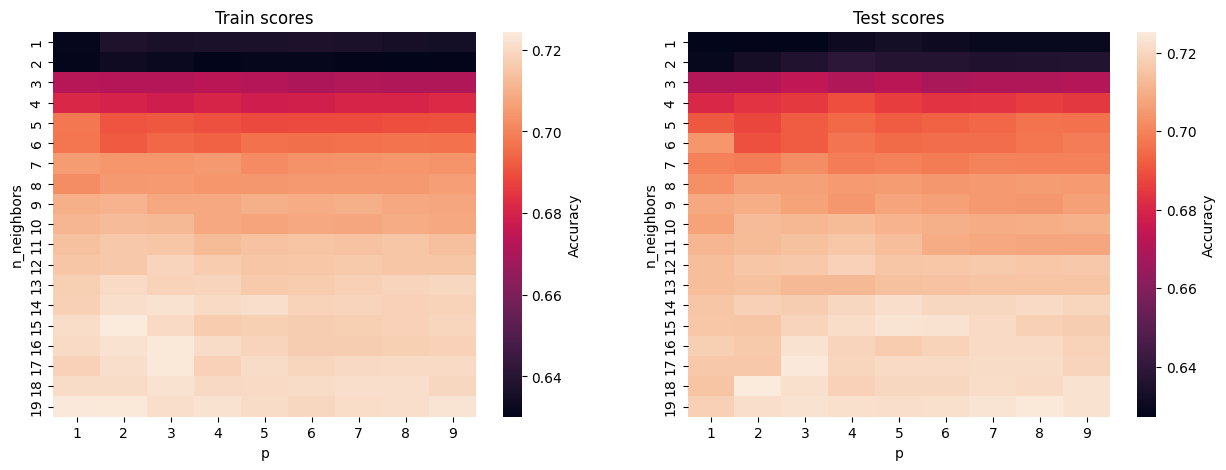

In [9]:
# parameters
class_model = KNeighborsClassifier()
n_neighbors = range(1,20)
P = range(1,10)

# to store scores
trainScore, testScore = np.zeros((len(n_neighbors), len(P))), np.zeros((len(n_neighbors), len(P)))

# get all the scores
for i, n in enumerate(n_neighbors):
    for j, p in enumerate(P):
        # get train scores using cv
        trainScore[i,j] = model_score(class_model, XTrain, yTrain, {'n_neighbors': n, 'p': p})
        # get test scores
        testScore[i,j] = class_model.score(XTest, yTest)

# set subplot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# add titles
ax1.set_title('Train scores');
ax2.set_title('Test scores');

# plot heatmaps
heatMapTrain = sns.heatmap(trainScore, ax = ax1, cbar_kws={'label': 'Accuracy'});
heatMapTest = sns.heatmap(testScore, ax = ax2, cbar_kws={'label': 'Accuracy'});

# set labels and ticks
heatMapTrain.set(xlabel='p', ylabel='n_neighbors', xticklabels=list(P), yticklabels=list(n_neighbors));
heatMapTest.set(xlabel='p', ylabel='n_neighbors', xticklabels=list(P), yticklabels=list(n_neighbors));

### c) Réglage des hyperparamètres avec les différentes fonctions

In [10]:
# to benchmark the hand written functions
def benchmark(class_model, XTrain, yTrain, XTest, yTest, f, f_para):
    # get execution time, training accuracy and the best parameters
    start = timer()
    trainAcc, bestPara = f(class_model = class_model, X = XTrain, y = yTrain, **f_para)
    end = timer()

    # set best parameters
    class_model.set_params(**bestPara)

    # get test accuracy
    testAcc = class_model.score(XTest, yTest)

    # return the results as a list
    return [float("{:.2f}".format(end - start)), float("{:.5f}".format(trainAcc)), float("{:.5f}".format(testAcc))] + list(bestPara.values())

# to benchmark the sklearn functions
def benchmarkSklearn(class_model, XTrain, yTrain, XTest, yTest, f, f_para):
    # construct the class
    f = f(estimator = class_model, **f_para)

    # get execution time of the fit phase
    start = timer()
    f.fit(XTrain, yTrain)
    end = timer()

    # get train accuracy
    trainAcc = f.best_score_

    # get test accuracy
    testAcc = f.score(XTest, yTest)

    # get best parameters
    bestPara = f.best_params_

    # return the results as a list
    return [float("{:.2f}".format(end - start)), float("{:.5f}".format(trainAcc)), float("{:.5f}".format(testAcc))] + list(bestPara.values())

In [11]:
# parameters
grille_param = {'n_neighbors' : n_neighbors, 'p' : P}
sample_percent = 30
n_splitting = 5
s_size = 5 
n_iter = 100

# to stock the results
perf = list()

# bruteforce_optimisation
res = benchmark(class_model, XTrain, yTrain, XTest, yTest, bruteforce_optimisation, {'grille_param' : grille_param})
perf.append(['bruteforce_optimisation'] + res)

# randomize_optimisation
res = benchmark(class_model, XTrain, yTrain, XTest, yTest, randomize_optimisation, {'grille_param' : grille_param, 'sample_percent' : sample_percent})
perf.append(['randomize_optimisation'] + res)

# halving_optimisation
res = benchmark(class_model, XTrain, yTrain, XTest, yTest, halving_optimisation, {'grille_param' : grille_param, 'n_splitting' : n_splitting})
perf.append(['halving_optimisation'] + res)

# bayesian_optimisation
res = benchmark(class_model, XTrain, yTrain, XTest, yTest, bayesian_optimisation, {'grille_param' : grille_param, 's_size' : s_size, 'n_iter' : n_iter})
perf.append(['bayesian_optimisation'] + res)

# GridSearchCV
res = benchmarkSklearn(class_model, XTrain, yTrain, XTest, yTest, GridSearchCV, {'param_grid' : grille_param, 'scoring' : 'accuracy'})
perf.append(['GridSearchCV'] + res)

# RandomizedSearchCV
res = benchmarkSklearn(class_model, XTrain, yTrain, XTest, yTest, RandomizedSearchCV, {'param_distributions' : grille_param, 'scoring' : 'accuracy', 'n_iter' : 60, 'random_state' : 0})
perf.append(['RandomizedSearchCV'] + res)

# HalvingGridSearchCV
res = benchmarkSklearn(class_model, XTrain, yTrain, XTest, yTest, HalvingGridSearchCV, {'param_grid' : grille_param, 'scoring' : 'accuracy', 'factor' : 5, 'random_state' : 0})
perf.append(['HalvingGridSearchCV'] + res)

In [12]:
# display as data frame
dfPerf = pd.DataFrame(perf, columns=['Function', 'Execution time (s)', 'Train acc.', 'Test acc.'] + list(grille_param.keys()))
dfPerf

,Function,Execution time (s),Train acc.,Test acc.,n_neighbors,p
0,bruteforce_optimisation,41.81,0.72443,0.71733,15,2
1,randomize_optimisation,11.86,0.72386,0.72233,19,1
2,halving_optimisation,59.15,0.72443,0.72100,15,2
3,bayesian_optimisation,25.63,0.72443,0.72100,15,2
4,GridSearchCV,41.70,0.72357,0.71600,16,3
5,RandomizedSearchCV,14.22,0.72357,0.71600,3,16
6,HalvingGridSearchCV,14.66,0.72240,0.71767,15,3


# COMMENTAIRE : TODO

### d) Comparaison

In [26]:
def getBenchmarkPlot(class_model, X, y, f, testSize, fBenchmark, fBenchmark_para, grid_param_name, grid_param):
    # get all the parameters combination for the function f 
    keys = fBenchmark_para.keys() # get parameters
    combinations = itertools.product(*fBenchmark_para.values()) # get all the parameters combinations 
    f_para = np.array([dict(zip(keys, comb)) for comb in combinations]) # zipped in list of dict

    # to store results for the plot after
    res = list()

    for para in f_para:
        res.append(list())
        for size in testSize:
            # split data
            XTrain, XTest, yTrain, yTest = train_test_split(X, y, test_size=size, random_state=0)
            # add grid parameters
            para[grid_param_name] = grid_param
            # get benchmark metrics
            metrics = fBenchmark(class_model, XTrain, yTrain, XTest, yTest, f, para)
            # delete the added key
            del para[grid_param_name]
            # store it
            res[-1].append(metrics)

    # convert to array for easy use
    res = np.array(res)

    # create the subplot
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    # titles
    titles = ['Execution time (s)', 'Train acc.', 'Test acc.']
    
    # plot
    for i, ax in enumerate(axes):
        # set labels
        ax.set_xlabel('p')
        ax.set_ylabel('n_neighbors')
        # set title 
        ax.set_title(titles[i])

        # plot scatter
        for j, m in enumerate(res):
            # get the label of the point
            label = str(f_para[j])
            for bestPara in m[:,[-2, -1]]:
                # plot point
                im = ax.scatter(bestPara[0], bestPara[1])
                # add label
                ax.annotate(label, (bestPara[0] - 0.5, bestPara[1] + 0.5))
            
        # add grid
        ax.grid(True)

        # plot
        plt.show() 

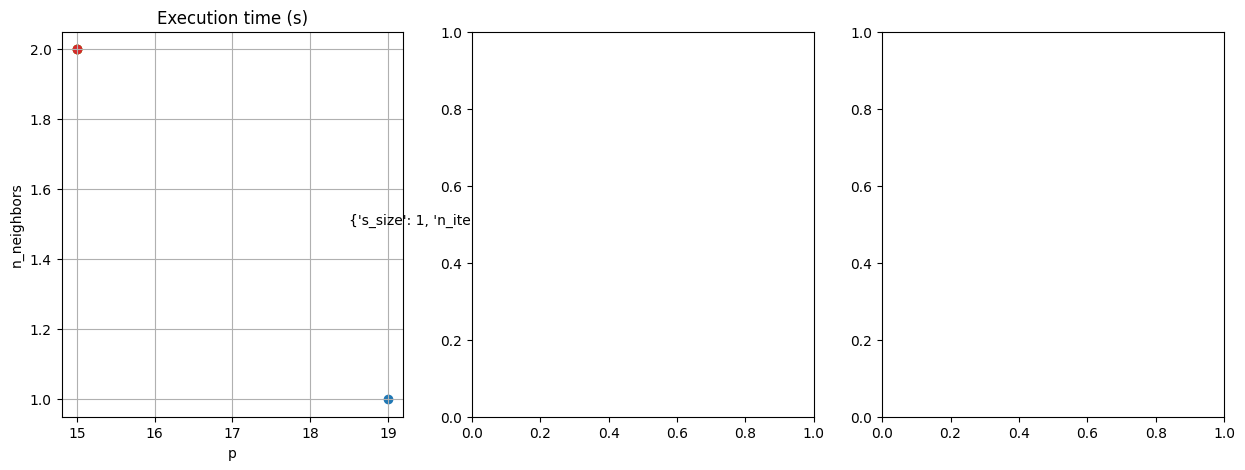

In [27]:
# parameters
testSize = [0.3]
benchmarkPara = {'s_size' : range(1,3), 'n_iter' : [50, 75]}

getBenchmarkPlot(class_model, X, y, bayesian_optimisation, testSize, benchmark, benchmarkPara, 'grille_param', grille_param)